In [1]:
import spacy
from spacy import displacy

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
from spacy.lang.en.stop_words import STOP_WORDS

In [4]:
stopwords = list(STOP_WORDS)
print(len(stopwords))

326


In [5]:
doc = nlp('This is my first step for learning spacy and nlp')
for token in doc:
    print(token.text, token.pos_)

This PRON
is AUX
my PRON
first ADJ
step NOUN
for ADP
learning VERB
spacy NOUN
and CCONJ
nlp VERB


In [6]:
displacy.render(doc, style='dep')

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

In [8]:
df_yelp = pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
df_amazon = pd.read_csv('amazon_cells_labelled.txt', sep='\t', header=None)
df_imdb = pd.read_csv('imdb_labelled.txt', sep='\t', header=None)

data = df_yelp.append([df_amazon, df_imdb], ignore_index=True)
columns_names = ['Review', 'Sentiment']
data.columns = columns_names

In [9]:
print(data.shape)
data.head()

(2748, 2)


,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Tokenization

In [10]:
import string
punct = string.punctuation
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Data cleaning

In [11]:
def text_data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ !="-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
             cleaned_tokens.append(token)
    return cleaned_tokens

In [12]:
text_data_cleaning(" The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering, and other natural language tasks.")

['universal',
 'sentence',
 'encoder',
 'encode',
 'text',
 'high',
 'dimensional',
 'vector',
 'use',
 'text',
 'classification',
 'semantic',
 'similarity',
 'clustering',
 'natural',
 'language',
 'task']

In [36]:
data1 = data.Review.apply(text_data_cleaning)
data1.head()

0                              [wow, ..., love, place]
1                                        [crust, good]
2                              [tasty, texture, nasty]
3    [stop, late, bank, holiday, rick, steve, recom...
4                      [selection, menu, great, price]
Name: Review, dtype: object

### Vectorization feature engineering (TF-IDF)

In [13]:
tfidf = TfidfVectorizer(tokenizer=text_data_cleaning)

In [14]:
X = data["Review"]
y = data["Sentiment"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [16]:
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [17]:
X_train= X_train.toarray()
X_test = X_test.toarray()

In [18]:
model = keras.Sequential()

model.add(keras.layers.Dense(units=256, input_shape=(X_train.shape[1], ), activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               959744    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1

In [19]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=16,
    validation_split=0.01,
    verbose=1, 
    shuffle=True
)

Epoch 1/20
136/136 [==============================] - 2s 10ms/step - loss: 0.6762 - accuracy: 0.5699 - val_loss: 0.6317 - val_accuracy: 0.7273
Epoch 2/20
136/136 [==============================] - 1s 8ms/step - loss: 0.4273 - accuracy: 0.8226 - val_loss: 0.6232 - val_accuracy: 0.7273
Epoch 3/20
136/136 [==============================] - 1s 9ms/step - loss: 0.2142 - accuracy: 0.9297 - val_loss: 0.7367 - val_accuracy: 0.7727
Epoch 4/20
136/136 [==============================] - 1s 9ms/step - loss: 0.1166 - accuracy: 0.9614 - val_loss: 0.7144 - val_accuracy: 0.7727
Epoch 5/20
136/136 [==============================] - 1s 9ms/step - loss: 0.0793 - accuracy: 0.9770 - val_loss: 0.8570 - val_accuracy: 0.7727
Epoch 6/20
136/136 [==============================] - 1s 8ms/step - loss: 0.0614 - accuracy: 0.9825 - val_loss: 0.8426 - val_accuracy: 0.7727
Epoch 7/20
136/136 [==============================] - 1s 8ms/step - loss: 0.0511 - accuracy: 0.9825 - val_loss: 0.7941 - val_accuracy: 0.7273
Epoch

In [21]:
y_pred = model.predict(X_test)
y_pred[0]

array([4.2110878e-07, 9.9999952e-01], dtype=float32)

In [29]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.72      0.76       279
           1       0.74      0.80      0.77       271

    accuracy                           0.76       550
   macro avg       0.76      0.76      0.76       550
weighted avg       0.76      0.76      0.76       550



In [22]:
print(y_test.iloc[0])

1


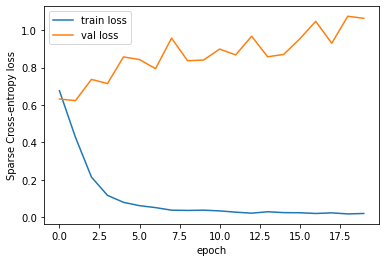

In [23]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Sparse Cross-entropy loss")
plt.legend();

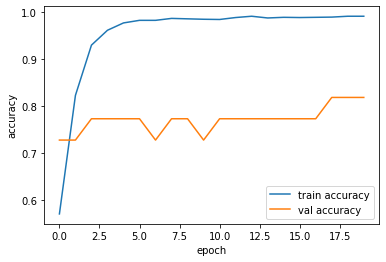

In [24]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [25]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 1.3188 - accuracy: 0.7618


[1.3188130855560303, 0.7618181705474854]